In [1]:
%reset -f
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyross

# Introduction and overview

## Model

In this notebook, we consider an SEAI5R model. Except for the lockdown protocol, the model considered here is the almost the same as in *examples/deterministic/ex11-SEAI5R-UK.ipynb*.

Differences between said notebook and the present one:
* We coarse grain the age groups, so that in this notebook we consider only 4 age groups (0-19, 20-39, 40-59, 60-79)
* For the fraction of symptomatic infectives that need to go to the hospital for these age groups we use 0.01, 0.05, 0.1, 0.1, reflecting that younger people are, on average, less affected by COVID-19.

## Protocol

We consider a protocol where a lockdown is imposed once the population in the ICU exceeds 1100 (chosen such that the following peak population in the ICU is below the ICU capacity of 4500).

We want to find the optimal times to release the lockdown in two stages:

* Stage 0: Full lockdown
* Stage 1: Release lockdown for age classes 0-19, 20-39. (Since parents of young children are often in the age group 20-39, I suppose it makes sense that either both age groups stay home, or both are released.)
* Stage 2: Release lockdown for all age classes, i.e. also for age classes 40-59 and 60-79.

During the full lockdown, the contact matrix is given by the home contact matrix $C_H$ of all age groups. For partial lockdowns the work, social, and other contact matrix elements involving all groups that are not in lockdown is added to this home contact matrix.


## Cost
We consider a cost function $C$ which is infinity if the ICU capacity is exceeded, and otherwise given by

\begin{equation}
    C = C_{lockdown} + C_{infection},
\end{equation}

where the cost of lockdown is given by

\begin{equation}
C_{lockdown} = \exp\left[ \kappa \cdot (T_1 +  T_2/5) \right],
\end{equation}

where $\kappa$ is the rate at which the cost of the lockdown increases, $T_1$ is the duration of stage 0 (full lockdown), and $T_2$ is the time of stage 1 (lockdown release for ages 0-39).

As cost of infection we choose

\begin{equation}
C_{infection} = \lambda\cdot I_{m}(t_f),
\end{equation}

where $I_m(t_f)$ is the total number of deceased at the final time of the simulation and $\lambda$ quantifies the cost of a life as compared to the cost of shutting down the economy.

## Optimisation task

We want to optimise the durations $T_1$, $T_2 >0$, i.e. we want to know how long an optimal lockdown lasts. For this, we minimise the cost function above with respect to $(T_1, T_2)$. For every evalulation of the cost function, we need to integrate the model dynamics; for this notebook, we assume deterministic dynamics.

The optimal durations of course depend on the parameters $(\kappa, \lambda)$ that appear in the cost function, and in the following we consider 

\begin{equation}
\lambda = 1,
\end{equation}

and the three values

\begin{equation}
\kappa = 10^{-6}, 10^{-3}, 1,
\end{equation}

corresponding to low economic cost, intermediate economic cost, and high economic cost.

### Load UK age structure and contact matrix

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

Ni[0] = np.sum(Ni0[0:4])
Ni[1] = np.sum(Ni0[4:8])
Ni[2] = np.sum(Ni0[8:12])
Ni[3] = np.sum(Ni0[12:16])
N=np.sum(Ni)

In [4]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = Ni0[i]*CH0[i,:]
    CS0[i,:] = Ni0[i]*CS0[i,:]
    CW0[i,:] = Ni0[i]*CW0[i,:]
    CO0[i,:] = Ni0[i]*CO0[i,:]

    
for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4,j1:j1+4]  )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4,j1:j1+4]  )/Ni[i]

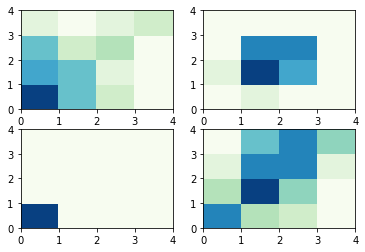

In [5]:
fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

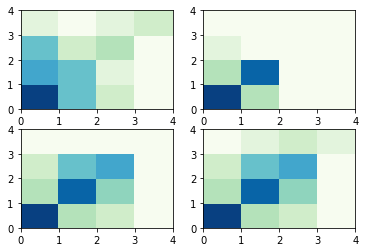

In [6]:
# Create contact matrix for age-dependent lockdown

# all locked in
C_0 = CH.copy()

# all but youngest two classes (0-19, 20-39) locked in
C_1 = CH.copy()
C_1[:2,:2] += CW[:2,:2] + CS[:2,:2] + CO[:2,:2]

# all but youngest three classes (0-19, 20-39, 40-59) locked in
C_2 = CH.copy()
C_2[:3,:3] += CW[:3,:3] + CS[:3,:3] + CO[:3,:3]

# nobody locked in
C_3 = CH + CW + CS + CO

C = CH + CW + CS + CO


fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(C_0, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(C_1, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(C_2, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(C_3, cmap=plt.cm.get_cmap('GnBu', 10));

### Define model parameters

In [7]:
beta  = 0.036692            # infection rate 

gE    = 1/5
gA    = 1/3
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 0.2                 # the self-isolation parameter   
fh    = 0
gIh   = 1/14
gIc   = 1/14
 
sa    = 0*np.ones(M)      #  rate of additional/removal of population by birth etc
sa[0]     = 1500            # birth
sa[3] = -300            # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
hh[0] = 0.01
hh[1] = 0.05
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC



# initial conditions    
Is_0 = np.zeros((M));  #Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4


Ia_0 = 1000*np.ones((M));  
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (E_0 + A_0 + Ia_0 + Is_0 + Ih_0 + Ic_0 +Im_0 + R_0)

### Define function to get list of events for a given protocol

In [8]:
def get_events(protocol,time_of_first_release = 300.):
    lockdown_threshold_1, lockdown_threshold_2 = protocol
    #
    events = []
    contactMatrices = []
    # Note that for technical reasons, the event functions take a
    # vector argument "rp" instead of a tuple (S, E, A, Ia, Is, Ih, Ic, Im).
    # When defining the event functions, the following correspondence has to be used:
    # S  == rp[ :M]
    # E  == rp[M:2*M]
    # A  == rp[2*M:3*M]
    # Ia == rp[3*M:4*M]
    # Is == rp[4*M:5*M]
    # Ih == rp[5*M:6*M]
    # Ic == rp[6*M:7*M]
    # Im == rp[7*M:8*M]
    #
    # This is a dummy event which will never occur; it is used to set the initial contact matrix
    def cur_event(t,rp):
        return t + 1
    cur_event.direction = +1
    events.append(cur_event)
    contactMatrices.append( C )
    #
    # Lockdown
    lockdown_threshold_0 = 1100
    def cur_event0(t,rp):
        return np.sum(rp[6*M:7*M]) - lockdown_threshold_0
    cur_event0.direction = +1 # this means we need to pass the threshold from below for the event to happen
    events.append(cur_event0)
    contactMatrices.append( C_0 ) # everybody in lockdown
    #
    # Release age groups 0-39
    #lockdown_threshold_1 = 300
    def cur_event1(t,rp):
        #return np.sum(rp[6*M:7*M]) - lockdown_threshold_1
        return t - lockdown_threshold_1
    cur_event1.direction = +1 # this means we need to pass the threshold from above for the event to happen
    events.append(cur_event1)
    contactMatrices.append( C_1 )
    # Release all age groups
    #lockdown_threshold_2 = 290
    def cur_event2(t,rp):
        #if t < time_of_first_release:
        #    return 1.
        #else:
        #    return np.sum(rp[6*M:7*M]) - lockdown_threshold_2
        return t - lockdown_threshold_2
    cur_event2.direction = +1 # this means we need to pass the threshold from above for the event to happen
    events.append(cur_event2)
    contactMatrices.append( C_3 ) # full contact matrix
    return events, contactMatrices


events, contactMatrices = get_events(protocol=[200,300])

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.control.SEAI5R(parameters, M, Ni)

# Run simulation
Tf = 5*365
Nt = (Tf +1)*10

result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0 ,
                        events=events,contactMatrices=contactMatrices,Tf=Tf, Nf=Nt,
                       repeat_events=False)

print(result['events_occured'])
#event_labels = ['','lockdown starts','lockdown ends']
#for i,e in enumerate(result['events_occured']):
#    print("After {0:3.1f} days, the {1}.".format(e[0],event_labels[e[1]]))

[[70.7446083000587, 1], [200.0, 2], [300.0, 3]]


In [9]:
def plot_result(t_arr,trajs,events_occured):
    # Plot result
    #t_arr = result['t']
    #trajs = result['X'].T
    fontsize=25
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title('SEAI5R, Population in ICU',
                y=1.05,fontsize=25)
    ax.axhline(4500,color='orange',
               lw=3,ls='--',
               label='ICU capacity')
    '''
    ax.axhline(lockdown_threshold_1,color='crimson',
               lw=3,
               label='Threshold for lockdown start')
    ax.axhline(lockdown_threshold_2,color='limegreen',
               lw=3,
              label='Threshold for lockdown end')
    ''';
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            color='crimson'
            if i < 2:
                label='Lockdown start'
            else:
                label= ''
        else:
            color='limegreen'
            if i < 2:
                label='Lockdown end'
            else:
                label= ''
        ax.axvline(e[0],label=label,
                   color=color,
                   lw=3,
                   ls='--',alpha=0.5)

    '''
    ax.plot(t_arr,np.sum(trajs[4*M:5*M],axis=0),
        label='Symptomatic infectives', 
        color='black',
        lw=2,
       )
    ''';
    ax.plot(t_arr,np.sum(trajs[6*M:7*M],axis=0),
        label='SEAI5R model', 
        color='black',
        lw=2,
       )
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_ylabel(r'$N_c$',fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    ax.legend(loc='upper right',bbox_to_anchor=(1.4,1.02),
              framealpha=1.,
             fontsize=15)
    plt.show(fig)
    #fig.savefig('threshold_driven_protocol_change_SEAI5R_UK.png',bbox_inches='tight',
    #           dpi=100)
    plt.close(fig)


    fontsize=25
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title('SEAI5R, Population in ICU',
                y=1.05,fontsize=25)
    ax.axhline(4500,color='orange',
               lw=3,ls='--',
               label='ICU capacity')
    '''
    ax.axhline(lockdown_threshold_1,color='crimson',
               lw=3,
               label='Threshold for lockdown start')
    ax.axhline(lockdown_threshold_2,color='limegreen',
               lw=3,
              label='Threshold for lockdown end')
    ''';
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            color='crimson'
            if i < 2:
                label='Lockdown start'
            else:
                label= ''
        else:
            color='limegreen'
            if i < 2:
                label='Lockdown end'
            else:
                label= ''
        ax.axvline(e[0],label=label,
                   color=color,
                   lw=3,
                   ls='--',alpha=0.5)

    '''
    ax.plot(t_arr,np.sum(trajs[4*M:5*M],axis=0),
        label='Symptomatic infectives', 
        color='black',
        lw=2,
       )
    ''';
    ax.plot(t_arr,np.sum(trajs[6*M:7*M],axis=0),
        label='SEAI5R model', 
        color='black',
        lw=2,
       )
    #ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_xlim(0,2*365)
    ax.set_ylim(0,5500)
    ax.set_ylabel(r'$N_c$',fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    #ax.legend(loc='upper right',bbox_to_anchor=(0.8,0.96),
    #          framealpha=1.,
    #         fontsize=15)
    plt.show(fig)
    #fig.savefig('threshold_driven_protocol_change_SEAI5R_UK.png',bbox_inches='tight',
    #           dpi=100)
    plt.close(fig)




    fontsize=25
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title('SEAI5R, Population in hospital',
                y=1.05,fontsize=25)
    #ax.axhline(4500,color='orange',
    #           lw=3,ls='--',
    #           label='ICU capacity')
    '''
    ax.axhline(lockdown_threshold_1,color='crimson',
               lw=3,
               label='Threshold for lockdown start')
    ax.axhline(lockdown_threshold_2,color='limegreen',
               lw=3,
              label='Threshold for lockdown end')
    ''';
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            color='crimson'
            if i < 2:
                label='Lockdown start'
            else:
                label= ''
        else:
            color='limegreen'
            if i < 2:
                label='Lockdown end'
            else:
                label= ''
        ax.axvline(e[0],label=label,
                   color=color,
                   lw=3,
                   ls='--',alpha=0.5)

    '''
    ax.plot(t_arr,np.sum(trajs[4*M:5*M],axis=0),
        label='Symptomatic infectives', 
        color='black',
        lw=2,
       )
    ''';
    ax.plot(t_arr,np.sum(trajs[5*M:6*M],axis=0),
        label='SEAI5R model', 
        color='black',
        lw=2,
       )
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    #ax.set_ylim(0,5500)
    ax.set_ylabel(r'$N_c$',fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    #ax.legend(loc='upper right',bbox_to_anchor=(0.8,0.96),
    #          framealpha=1.,
    #         fontsize=15)
    plt.show(fig)
    #fig.savefig('threshold_driven_protocol_change_SEAI5R_UK.png',bbox_inches='tight',
    #           dpi=100)
    plt.close(fig)
    
#plot_result(result['t'],result['X'].T,result['events_occured'])

### Define cost function

In [10]:
'''
def evaluate_cost_function(t_arr,traj,protocol,events_occured,
                           prefactor_economic_cost=1.,
                           rate_economic_cost=1/7.,
                              prefactor_mortality_cost=10.):
    #global time_of_first_release
    if (np.array(protocol) < 0).any():
        return np.inf
    #if protocol[0] < protocol[1]:
    #    return np.inf
    #
    cost = 0.
    #
    have_lockdown_start = False
    have_lockdown_end_0 = False
    have_lockdown_end_1 = False
    #
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            lockdown_start = e[0]
            have_lockdown_start = True
        elif e[1] == 2:
            lockdown_end_0 = e[0]
            have_lockdown_end_0 = True
        elif e[1] == 3:
            lockdown_end_1 = e[0]
            have_lockdown_end_1 = True
    if have_lockdown_start:
        if have_lockdown_end_0:
            cost += prefactor_economic_cost* np.exp(rate_economic_cost* (lockdown_end_0-lockdown_start))
        else:
            cost += np.inf
        #
        if have_lockdown_end_0 and have_lockdown_end_1:
            cost *=  np.exp(0.2*rate_economic_cost* (lockdown_end_1-lockdown_end_0))
    #for i,e in enumerate(lockdowns):
    #    cost += 10*np.exp(e[1]/7.)
    if np.max( np.sum( traj[6*M:7*M],axis=0 ) ) > 4500:
        return np.inf
    #
    cost += prefactor_mortality_cost * np.sum( traj[7*M:8*M,-1]  )
    #print(cost/prefactor_mortality_cost)
    #
    return cost
''';

def evaluate_cost_function(t_arr,traj,protocol,events_occured,
                           prefactor_economic_cost=1.,
                           rate_economic_cost=1/7.,
                              prefactor_mortality_cost=10.):
    #global time_of_first_release
    if (np.array(protocol) < 0).any():
        return np.inf
    if protocol[0] > protocol[1]:
        return np.inf
    #
    cost = 0.
    #
    have_lockdown_start = False
    have_lockdown_end_0 = False
    have_lockdown_end_1 = False
    #
    for i,e in enumerate(events_occured):
        if e[1] == 1:
            lockdown_start = e[0]
            have_lockdown_start = True
        elif e[1] == 2:
            lockdown_end_0 = e[0]
            have_lockdown_end_0 = True
        elif e[1] == 3:
            lockdown_end_1 = e[0]
            have_lockdown_end_1 = True
    if have_lockdown_start:
        if have_lockdown_end_0:
            cost += prefactor_economic_cost* np.exp(rate_economic_cost* (lockdown_end_0-lockdown_start))
        else:
            cost += np.inf
        #
        if have_lockdown_end_0 and have_lockdown_end_1:
            cost *=  np.exp(0.2*rate_economic_cost* (lockdown_end_1-lockdown_end_0))
    #for i,e in enumerate(lockdowns):
    #    cost += 10*np.exp(e[1]/7.)
    if np.max( np.sum( traj[6*M:7*M],axis=0 ) ) > 4500:
        return np.inf
    #
    cost += prefactor_mortality_cost * np.sum( traj[7*M:8*M,-1]  )
    #print(cost/prefactor_mortality_cost)
    #
    return cost



def evaluate_cost_of_protocol(model,protocol,
                             verbose=False,return_trajectory=False,
                              prefactor_economic_cost=10.,
                              rate_economic_cost=1/7.,
                             prefactor_mortality_cost=10.):
    #
    events, contactMatrices = get_events(protocol)
    # intantiate model
    parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
                  'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
                  'fsa':fsa, 'fh':fh, 
                  'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
    # Run simulation
    Tf = 2000
    Nt = (Tf +1)*10
    result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0 ,
                            events=events,contactMatrices=contactMatrices,Tf=Tf, Nf=Nt,
                           repeat_events=False)
    #
    
    cost = evaluate_cost_function(t_arr=result['t'],
                                   traj=result['X'].T,
                                   protocol=protocol,
                                  events_occured=result['events_occured'],
                                  prefactor_economic_cost=prefactor_economic_cost,
                                  rate_economic_cost=rate_economic_cost,
                                  prefactor_mortality_cost=prefactor_mortality_cost)
    if return_trajectory:
        return cost, result['t'], result['X'].T, result['events_occured']
    else:
        return cost
    
    
protocol=[170,400]
model = pyross.control.SEAI5R(parameters, M, Ni)


cost, t_arr, traj, events_occured = evaluate_cost_of_protocol(model=model,
                                             protocol=protocol,
                                              return_trajectory=True)

In [11]:
#plot_result(t_arr,traj,events_occured)

## Extreme example: economic cost = 0

In [12]:
def minimizing_function(prefactor_mortality_cost,
                        rate_economic_cost,
                        protocol):
    # For the cma-es algorithm we want numbers that are of the order 1, 
    # that is why the argument of this function is taking the protocol in units
    # of weeks. 
    # For the other functions we wrote, we use the protocol in units of
    # days, so that we now convert:
    #days_per_week = 7
    #protocol_in_units_of_days = protocol_in_units_of_weeks*days_per_week
    # evaluate cost
    costs = evaluate_cost_of_protocol(model=model,
                                             protocol=protocol,
                                      rate_economic_cost=rate_economic_cost,
                                      prefactor_mortality_cost=prefactor_mortality_cost,
                                              return_trajectory=False)
    #print(costs)
    return costs # we actually return the log

    
protocol=[170,400]
model = pyross.control.SEAI5R(parameters, M, Ni)

minimizing_function(1e3,0.1,protocol)

46427257.46475472

In [13]:
Initial_condition = [170.,400.] 



from multiprocessing import Pool 
import cma
import time

number_of_threads = 4
number_iterations = 1000
p = Pool(number_of_threads)

options = cma.CMAOptions()
#options['bounds'] = [bounds[:, 0], bounds[:, 1]]
#options['tolfunrel'] = ftol
options['popsize'] = 12

# This allows us have a different scale for sigma in each dimension.
#options['CMA_stds'] = bounds[:,1] - bounds[:,0]

from functools import partial


prefactor_mortality_cost = 1.
rate_economic_cost = 0.1


start_time = time.time()
#optim = cma.CMAEvolutionStrategy(Initial_condition, 2e-1, options)
optim = cma.CMAEvolutionStrategy(Initial_condition, 1., options)
iteration = 0
while not optim.stop() and iteration < 1: #number_iterations:
    positions = optim.ask()
    func = partial(minimizing_function, prefactor_mortality_cost, rate_economic_cost)
    values = p.map(func, positions)
    optim.tell(positions, values)
    optim.disp()
    iteration += 1

end_time = time.time()
print("Time: ", end_time - start_time)
print("Value: ", optim.best.f)
print("Parameters: ",optim.best.x)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 2 (seed=473909, Fri May  1 20:34:49 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.709219405960264e+07 1.0e+00 1.55e+00  2e+00  2e+00 0:01.1
Time:  1.0763802528381348
Value:  17092194.059602637
Parameters:  [168.05678459 398.99746177]


In [14]:
number_iterations = 1000


prefactor_mortality_costs = np.array( [1.] )
rate_economic_costs = np.array( [0.000001,0.001,1.] )


Initial_conditions =[ [170,1000.],
                      [170,400.],
                     [170,400.]]

if False:
    optimal_protocols = np.zeros([len(prefactor_mortality_costs),len(rate_economic_costs),2],dtype=float)
    for i,prefactor_mortality_cost in enumerate(prefactor_mortality_costs):
        for j,rate_economic_cost in enumerate(rate_economic_costs):
            print(prefactor_mortality_cost,rate_economic_cost)
            optim = cma.CMAEvolutionStrategy(Initial_conditions[j], 1., options)
            iteration = 0
            while not optim.stop() and iteration < number_iterations:
                positions = optim.ask()
                func = partial(minimizing_function, prefactor_mortality_cost, rate_economic_cost)
                values = p.map(func, positions)
                optim.tell(positions, values)
                optim.disp()
                iteration += 1
            #print("Parameters: ",optim.best.x)
            optimal_protocols[i,j] = optim.best.x
    #np.save('optimal_protocols.npy',optimal_protocols)
    #np.save('prefactor_mortality_costs.npy',prefactor_mortality_costs)
    #np.save('rate_economic_costs.npy',rate_economic_costs)
else:
    optimal_protocols = np.load('optimal_protocols.npy')
    prefactor_mortality_costs = np.load('prefactor_mortality_costs.npy')
    rate_economic_costs = np.load('rate_economic_costs.npy')

In [15]:
#np.save('optimal_protocols.npy',optimal_protocols)
#np.save('prefactor_mortality_costs.npy',prefactor_mortality_costs)
#np.save('rate_economic_costs.npy',rate_economic_costs)

In [16]:
print(optimal_protocols)

[[[ 179.18964837 1002.3190799 ]
  [ 114.84831826  328.85201659]
  [ 114.84831826  231.49582688]]]


In [17]:
list_of_trajectories = []
for i,e in enumerate(prefactor_mortality_costs):
    cur_list = []
    for j,f in enumerate(rate_economic_costs):
        #
        events, contactMatrices = get_events(optimal_protocols[i,j])
        #
        cost, t_arr, traj, events_occured = evaluate_cost_of_protocol(model=model,
                                             protocol=optimal_protocols[i,j],
                                              return_trajectory=True)
        #
        cur_list.append( [ cost, t_arr, traj, events_occured ] )
    list_of_trajectories.append(cur_list)

Deceased population: 20212


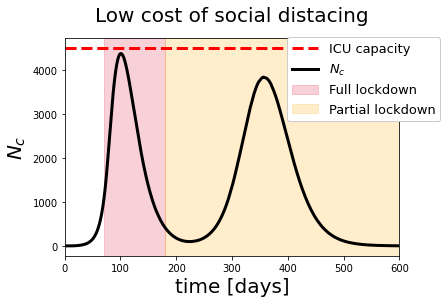

Deceased population: 23716


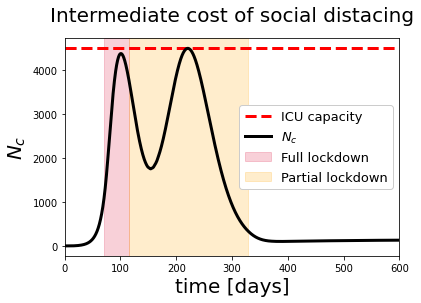

Deceased population: 31252


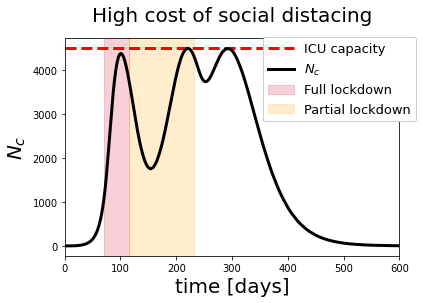

In [46]:
fontsize=20

#labels = ['Low economic cost','Intermediate economic cost','Large economic cost']
labels = ['Low cost of social distacing',
          'Intermediate cost of social distacing',
          'High cost of social distacing']
for i,e in enumerate(list_of_trajectories[0]):
    #
    cost, t_arr, traj, events_occured = e
    print('Deceased population: {0:3.0f}'.format(np.sum(traj[7*M:8*M,-1],axis=0)))
    #
    for j,e in enumerate(events_occured):
        #print(e)
        if e[1] == 1:
            lockdown_start = e[0] 
        if e[1] == 2:
            lockdown_release_1 = e[0]
        if e[1] == 3:
            lockdown_release_2 = e[0]
    #
    fig,ax = plt.subplots(1,1,figsize=(6,4))
    ax.set_title(labels[i],fontsize=20,y=1.05)
    ax.axhline(4500,label='ICU capacity',color='red',lw=3,
              ls='--')
    #ax.axvline(lockdown_start,lw=1,ls='--',color='red')
    ax.axvspan(lockdown_start,lockdown_release_1,
               label='Full lockdown',
              alpha=0.2,color='crimson')
    ax.axvspan(lockdown_release_1,lockdown_release_2,
                              label='Partial lockdown',
              alpha=0.2,color='orange')
    ax.plot(t_arr,np.sum(traj[6*M:7*M],axis=0),
            label=r'$N_c$',
            color='black',
            lw=3,
           )
    ax.set_xlim(0,600)
    if i == 0:
        ax.legend(loc='upper right',bbox_to_anchor=(1.142,1.0345),
                  fontsize=13,framealpha=1.)
    elif i == 2:
        ax.legend(loc='upper right',bbox_to_anchor=(1.07,1.0343),
                  fontsize=13,framealpha=1.)
    else:
        ax.legend(loc='best',fontsize=13,framealpha=1.)
    ax.set_xlabel('time [days]',fontsize=fontsize)
    ax.set_ylabel(r'$N_c$',fontsize=fontsize)
    plt.show(fig)
    fig.savefig('optimal_protocol_{0}.png'.format(i),bbox_inches='tight',dpi=100)
    fig.savefig('optimal_protocol_{0}.jpg'.format(i),bbox_inches='tight',dpi=200)
    plt.close(fig)